# Template fits: comparing two chi-square distributed test statistics

The builtin binned cost functions in `iminuit.cost` provide a method `pulls` which returns the pull distribution for a given data set. The sum of pulls squared is asymptotically chi-square distributed, but as is explained in the documentation, it is better to use the minimum value of the cost function instead of the pulls to compute this test statistic. The reason is that the cost function has been designed so that the minimum is chi-square distributed and it approaches the asymptotic limit faster than a simple sum of pulls squared.

We demonstrate this in this example for a Template fit. We generate random samples from a mixed model (gaussian peak over exponential background), which is fitted many times. The distribution of the cost function minimum and alternatively the sum of pulls squared is compared with a chi-square distribution by computing p-values based on the expected distribution. If the test statistic follows the chi-square distribution, the distribution of p-values must be uniform.

In [16]:
from iminuit import cost, Minuit
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import chi2
from IPython.display import display

In [17]:
xr = (0, 2)  # xrange
rng = np.random.default_rng(1)

nmc = 1000
trials = 1000

data = {}
data2 = {}

first = True
for trial in range(trials):
    for bins in (20, 200,):
        xdata = rng.normal(1, 0.1, size=1000)
        ydata = rng.exponential(size=len(xdata))
        xmix = np.append(xdata, ydata)
        xmix = xmix[(xr[0] < xmix) & (xmix < xr[1])]

        n, xe = np.histogram(xmix, bins=bins, range=xr)

        x = rng.normal(1, 0.1, size=nmc)
        y = rng.exponential(size=nmc)
        t = [
            np.histogram(x, bins=bins, range=xr)[0],
            np.histogram(y, bins=bins, range=xr)[0],
        ]
        c = cost.Template(n, xe, t)
        m = Minuit(c, 1, 1)
        m.migrad()
        assert m.valid
        assert m.accurate
        data.setdefault(bins, []).append(m.fmin.fval)
        data2.setdefault(bins, []).append(np.nansum(c.pulls(m.values) ** 2))
        # display one example fit
        if first:
            display(m)
    first = False

for key in tuple(data):
    val = data[key]
    data[key] = np.array(val)
    val = data2[key]
    data2[key] = np.array(val)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.87 (χ²/ndof = 0.8)      │              Nfcn = 101              │
│ EDM = 2.91e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.01e3   │  0.05e3   │            │            │    0    │         │       │
│ 1 │ x1   │    870    │    50     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 2.49e+03   -0.5e3 │
│ x1 │   -0.5e3 2.21e+03 │
└────┴───────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 201.8 (χ²/ndof = 1.0)      │              Nfcn = 100              │
│ EDM = 2.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  1.02e3   │  0.05e3   │            │            │    0    │         │       │
│ 1 │ x1   │    810    │    40     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 2.41e+03   -0.3e3 │
│ x1 │   -0.3e3 1.92e+03 │
└────┴───────────────────┘

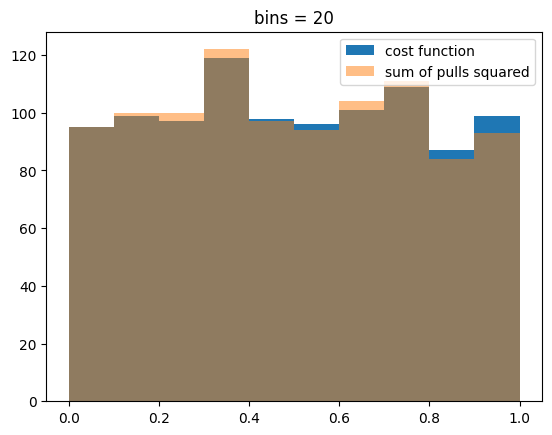

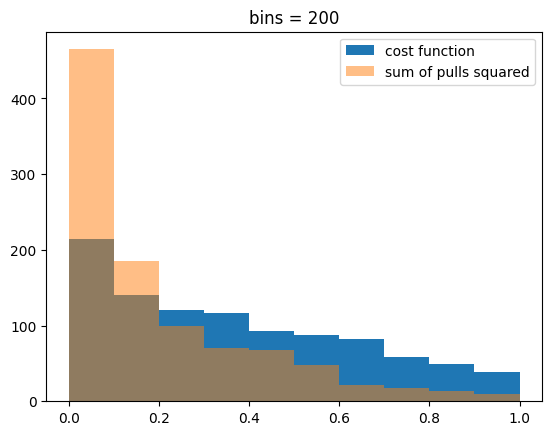

In [18]:
for bins in data:
    plt.figure()
    plt.title(f"bins = {bins}")
    plt.hist(chi2(bins-2).cdf(data[bins]), bins=10, range=(0, 1), label="cost function")
    plt.hist(chi2(bins-2).cdf(data2[bins]), bins=10, range=(0, 1), alpha=0.5, label="sum of pulls squared")
    plt.legend();

When 20 bins are used, the number of counts per bin is large enough so that both test statistics are chi-square distributed. When 200 bins are used with samples of the same size, the density in some bins drops low enough so that we are not in the asymptotic limit and see deviations from the theoretical chi-square distribution. These deviations are larger for the sum of pulls squared.